# HLS Quality assessment notebook for QA-masked monthly median per pixel reflectance

This notebook does basic quality assessment of a single tile of your choice collected in previous notebooks by examining the output zarr of the `calculate_job_median` function. It specifically examines the output for the NIR_NARROW band in January and July, to assess quality and cloud masking in different seasons.

## Get the basics set up

In [6]:
import os
import sys
sys.path.append('..')

# pip/conda installed
import fsspec
import pandas as pd
import xarray as xr

from utils import get_logger
from utils.hls.catalog import HLSBand
from utils.hls.catalog import HLSCatalog
from utils.hls import compute

In [2]:
logger = get_logger('hls-masked-monthly-median-qa')

In [2]:
# fill with your account key
%store -r envdict

In [7]:
code_path = '../utils'
cluster_args = dict(
    workers=4,
    worker_threads=1,
    worker_memory=8,
    scheduler_threads=1,
    scheduler_memory=4,
    clust_type='local'
)

## Get the catalog and cluster ready

The example below uses a local cluster and a 2018 catalog for the tile covering Seattle (10TET). Change the lat, lon, and year below to preview other tiles. **If the tile you want to preview has already been collected, you can skip the cells under "Run Job"**

In [8]:
bands = [HLSBand.NIR_NARROW, HLSBand.QA]
seattle_df = pd.DataFrame([{'lat': 47.6062, 'lon': -122.3321, 'year': 2018}])
catalog = HLSCatalog.from_point_pandas(seattle_df, bands)
catalog.xr_ds

Reading tile extents...
Read tile extents for 56686 tiles
Searching for matching Landsat scenes...


100%|██████████| 1/1 [00:01<00:00,  1.30s/it]


Searching for matching Sentinel scenes...


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


<xarray.Dataset>
Dimensions:  (index: 173)
Coordinates:
  * index    (index) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    lat      (index) float64 47.61 47.61 47.61 47.61 ... 47.61 47.61 47.61 47.61
    lon      (index) float64 -122.3 -122.3 -122.3 ... -122.3 -122.3 -122.3
    year     (index) int64 2018 2018 2018 2018 2018 ... 2018 2018 2018 2018 2018
    tile     (index) object '10TET' '10TET' '10TET' ... '10TET' '10TET' '10TET'
    scene    (index) object 'L30/HLS.L30.T10TET.2018006.v1.4' ... 'S30/HLS.S3...
    sensor   (index) object 'L' 'L' 'L' 'L' 'L' 'L' ... 'S' 'S' 'S' 'S' 'S' 'S'
    dt       (index) datetime64[ns] 2018-01-06 2018-01-13 ... 2018-12-29
Attributes:
    bands:    [<HLSBand.NIR_NARROW: 5>, <HLSBand.QA: 11>]

## Run the Job

This should take a minute or two to complete

In [6]:
# calculate_job_median args
account_name=envdict['AZURE_STRG_ACCOUNT_NAME']
storage_container=envdict["TILE_BLOB_CONTAINER"]
account_key=envdict["AZURE_ACCOUNT_KEY"]
job_groupby = "time.month"
# read the entire data once (each tile is 3660x3660)...
chunks = {'band': 1, 'x': 3660, 'y': 3660}

In [7]:
catalog_groupby = "tile"
jobs = compute.jobs_from_catalog(catalog.xr_ds, catalog_groupby)
compute.process_jobs(
    jobs=jobs,
    job_fn=compute.calculate_job_median,
    checkpoint_path='qa_chk_pt.txt',
    logger=logger,
    cluster_args=cluster_args,
    code_path=code_path,
    concurrency=1,  # run 1 job at once
    cluster_restart_freq=-1,  # don't restart cluster
    job_groupby=job_groupby,
    bands=bands,
    chunks=chunks,
    account_name=account_name,
    storage_container=storage_container,
    account_key=account_key,
)

2021-01-28 01:16:06,191 [INFO] hls-masked-monthly-median-qa - Starting cluster
2021-01-28 01:16:16,075 [INFO] hls-masked-monthly-median-qa - Cluster dashboard visible at /services/dask-gateway/clusters/default.19f8afba79fb4675962c02fb1dc00828/status
2021-01-28 01:16:16,099 [INFO] hls-masked-monthly-median-qa - Uploading code to cluster
2021-01-28 01:16:16,102 [INFO] hls-masked-monthly-median-qa - Submitting job 10TET
2021-01-28 01:18:40,557 [INFO] hls-masked-monthly-median-qa - Completed job 10TET
2021-01-28 01:18:40,594 [INFO] hls-masked-monthly-median-qa - Metrics: {"job_errors": 0, "job_skips": 0, "job_completes": 1, "time": 154.4038594190497}


## Quality assessment

1. Read the file from Azure blob storage
1. Examine the NIR_NARROW band in July and assert the reflectance values are within bounds and then visually examine the output
1. Examine the NIR_NARROW band in January and assert the reflectance values are within bounds and then visually examine the output

In [8]:
tile_path_str = f"{envdict['TILE_BLOB_CONTAINER']}/{catalog.xr_ds.data_vars['tile'].to_numpy()[0]}.zarr"
tile_path = fsspec.get_mapper(
    f"az://{tile_path_str}",
    account_name="usfs",
    account_key=os.environ['AZURE_ACCOUNT_KEY']
)
tile = xr.open_zarr(tile_path)

<xarray.Dataset>
Dimensions:     (month: 12, x: 3660, y: 3660)
Coordinates:
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * x           (x) float64 5e+05 5e+05 5.001e+05 ... 6.097e+05 6.098e+05
  * y           (y) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
Data variables:
    NIR_NARROW  (month, y, x) float64 dask.array<chunksize=(1, 3660, 3660), meta=np.ndarray>
Attributes:
    ACCODE:                    LaSRCL8V3.5.5
    AREA_OR_POINT:             Area
    DATA_TYPE:                 L1TP
    HLS_PROCESSING_TIME:       2018-05-16T12:20:08Z
    HORIZONTAL_CS_NAME:        UTM, WGS84, UTM ZONE 10
    L1_PROCESSING_TIME:        2018-01-19T02:54:03Z
    LANDSAT_PRODUCT_ID:        LC08_L1TP_046027_20180106_20180119_01_T2
    LANDSAT_SCENE_ID:          LC80460272018006LGN00
    MEAN_SUN_AZIMUTH_ANGLE:    161.17728918
    MEAN_SUN_ZENITH_ANGLE:     72.02821969
    NBAR_Solar_Zenith:         49.6158554919819
    NCOLS:                     3660
    NROWS:                     3660
    SENSING_TIME:              2018-01-06T18:55:46.2144129Z
    SENSOR:                    OLI_TIRS
    SENTINEL2_TILEID:          10TET
    SPATIAL_RESOLUTION:        30
    TIRS_SSM_MODEL:            FINAL
    TIRS_SSM_POSITION_STATUS:  ESTIMATED
    ULX:                       499980
    ULY:                       5300040
    USGS_SOFTWARE:             LPGS_13.0.0
    _FillValue:                -1000
    add_offset:                0.0
    arop_ave_xshift(meters):   -13.7999999999884
    arop_ave_yshift(meters):   -21.5
    arop_ncp:                  309
    arop_rmse(meters):         3.61
    arop_s2_refimg:            /nobackupp6/jju/S2REFIMG/10TET.2016.8.29.0.S2A...
    cloud_coverage:            100
    crs:                       +init=epsg:32610
    descriptions:              ['NIR']
    is_tiled:                  1
    long_name:                 NIR
    nodatavals:                [-1000.0]
    offsets:                   [0.0]
    res:                       [30.0, 30.0]
    scale_factor:              0.0001
    scales:                    [0.0001]
    spatial_coverage:          100
    transform:                 [30.0, 0.0, 499980.0, 0.0, -30.0, 5300040.0]

In [9]:
def assert_bounds(arr, minimum, maximum):
    mi = float(arr.min().values)
    ma = float(arr.max().values)
    print(mi, ma)
    assert mi >= minimum and ma <= maximum, "Out of bounds"

0.0 0.8624


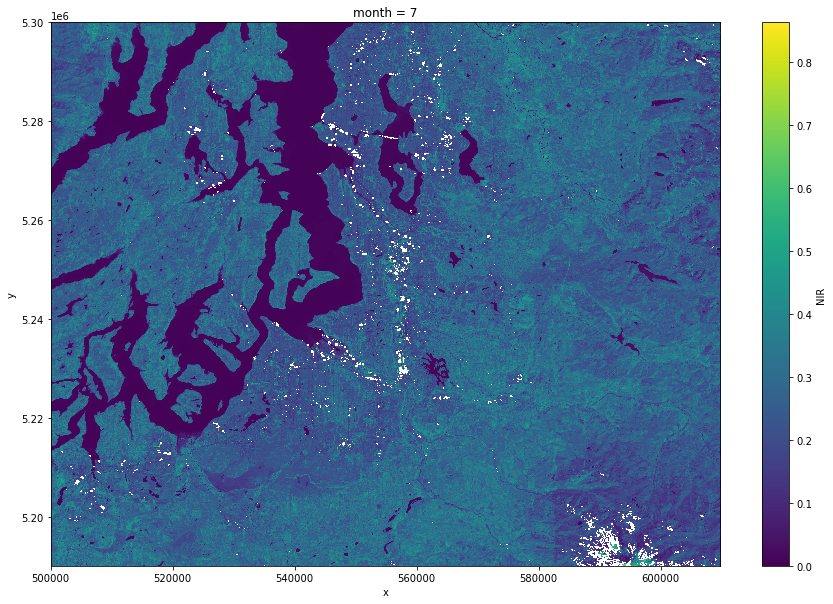

In [10]:
# July in Seattle...Shouldn't be missing too much data
july = tile.sel(month=7)['NIR_NARROW'].persist()
assert_bounds(july, 0, 1)
july.plot.imshow(size=10)

0.0 0.9954000000000001


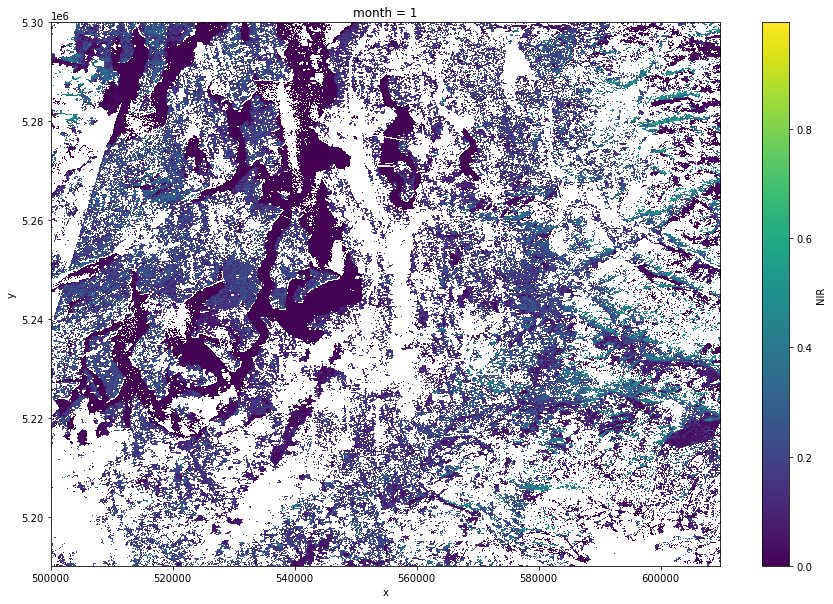

In [11]:
# January in Seattle...should have a lot of missing data
jan = tile.sel(month=1)['NIR_NARROW'].persist()
assert_bounds(jan, 0, 1)
jan.plot.imshow(size=10)